# Language Detection

### Import Statements 

In [62]:
import os

import iso639 
import langid
import fasttext
import langdetect
import fasttext.util
from fasttext.FastText import _FastText


from iso639 import *
from langdetect import *
from keras.utils import *
from sklearn.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

le = LabelEncoder()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Useful Functions

- Text Cleaning

In [63]:
def clean(Text):
    """
    Clean text by removing newlines, tabs, and double spaces.

    Args:
        text (str or pandas.Series): Text data to clean. If a pandas Series is passed, 
            the cleaning is applied element-wise.

    Returns:
        str or pandas.Series: Cleaned text.

    """
    Text = Text.apply(lambda x: x.replace("\n", " "))
    Text = Text.apply(lambda x: x.replace("\t", " "))
    Text = Text.apply(lambda x: x.replace("  ", " "))
    return Text

- ISO Language Code to Language Name

In [64]:
def iso2str(text):
    '''
    Convert ISO language code to language name in string format.
    
    Args:
        text (str): ISO language code

    Returns:
        str: Language name in string format, or 'unknown' if the code is invalid.
    '''
    try:
        return languages.get(alpha2=text).name
    except:
        return 'unknown'

- LangDetect Prediction

In [65]:
def check_lang(text):
    '''Detects the language of the input text using Langdetect.
    
    Args:
        param text (str) : Input text
    Returns:
        str : Two-letter language code if language is detected, otherwise returns "unknown".
    '''
    try:
        lang = detect(str(text))
    except lang_detect_exception.LangDetectException:
        lang = 'unknown'
    return lang   

- FastText Prediction 

In [66]:
class LanguageIdentification:
    """
    A class for identifying the language of a given input text using a pre-trained fasttext language model.

    Attributes:
        model (fasttext.FastText._FastText): The pre-trained fasttext language model.

    Methods:
        predict_lang(text: str) -> str:
            Identifies the language of the given input text using the pre-trained fasttext language model.
    """

    def __init__(self):
        """
        Initializes the LanguageIdentification class by loading the pre-trained fasttext language model.
        """
        pretrained_lang_model = "../models/lid.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text: str) -> str:
        """
        Identifies the language of the given input text using the pre-trained fasttext language model.

        Args:
            text (str): The input text whose language is to be identified.

        Returns:
            str: The identified language of the input text.
        """
        predictions = self.model.predict(text, k=1) 
        predictions = predictions[0][0].replace("__label__", "")
        return predictions


- Custom Evaluation Report

In [67]:
def multiclass_report(y_true, y_pred, labels):
    '''
    Calculates and displays the accuracy, precision, and recall for the classification of a multiclass problem.

    Args:
        y_true (array-like): True labels for the data.
        y_pred (array-like): Predicted labels for the data.
        labels (list-like): List of unique class labels in the data.

    Returns:
        None

    Prints the accuracy, precision, and recall for the classification.
    Displays a confusion matrix as a heatmap.
    '''
    
    print(f'Accuracy: {np.mean(y_true == y_pred)}\nPrecision: {np.mean(y_true == y_pred)}\nRecall: {np.mean(y_true == y_pred)}')
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

- Embedding using SentenceTransformer 

In [68]:
st = SentenceTransformer('all-MiniLM-L6-v2')

def stEmbedding(text, model = 'model'):
    '''
    Embed the given text using Sentence Transformer.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''
    return st.encode(text)


- Embedding using FastText

In [69]:
ft = _FastText('../models/lid.bin')
def ftEmbedding(text):
    '''
    Embed the given text using a Fasttext.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''

    return ft.get_sentence_vector(text)

- T-Stocastic Neighbour Embedding Plot

In [70]:
def Tsen(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays a scatter plot of the word embeddings in the reduced dimensional space.
    '''
    X = np.array(Embedding.tolist())
    y = Language.values
    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)

    plt.figure(figsize=(10, 10))
    for i, lang in enumerate(Language.unique()):
        plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

    plt.legend()
    plt.show()

- Interactive Plot using Plotly 

In [71]:
def Plotly(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm and Plotly library.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays an interactive scatter plot of the word embeddings in the reduced dimensional space.
    '''
    
    X = np.array(Embedding.tolist())
    y = Language.values

    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)
    fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y, width=600, height=600)
    fig.show()

- Data Splitting Function 

In [72]:

def split_train_test_data(Embedding, Language):
    '''
    Splits the data into training and testing sets, and applies label encoding to the target variable.

    Args:
    - Embedding (DataFrame): DataFrame containing the embedding vectors.
    - Language (DataFrame): DataFrame containing the target variable.

    Returns:
    - X_train, X_test, y_train, y_test (numpy.ndarray): The training and testing data and target variables.
    '''
    
    X = np.array(Embedding.tolist())

    y = Language.values
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

- All in One Wrapper for creating Custom model _(OLD)_ 

In [73]:
def createModel(model_type, num_layers, layer_types, layer_units, input_shape):
    '''Create a deep learning model with specified architecture.

    Args:
        model_type (str): The type of model to create. Supported values are
            'Sequentials', 'LSTM', and 'Convolutional'.
        num_layers (int): The number of layers to include in the model.
        layer_types (list[str]): A list of layer types to include in the model.
        layer_units (list[int]): A list of the number of units for each layer in the model.
        input_shape (tuple[int]): The shape of the input data.
        output_units (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported model type is specified.
    '''

    model = Sequential()
    if model_type == 'Sequentials':
        for i in range(num_layers):
            if layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
    
    elif model_type == 'LSTM':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'LSTM':
                model.add(LSTM(layer_units[i], input_shape=input_shape))
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")

    elif model_type == 'Convolutional1D':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'Conv1D':
                model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling1D':
                model.add(MaxPooling1D(pool_size=2))
            elif layer_types[i] == 'Conv2D':
                model.add(Conv2D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling2D':
                model.add(MaxPooling2D(pool_size=2))
            elif layer_types[i] == 'Flatten':
                model.add(Flatten())
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")

    elif model_type == 'Convolutional2D':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'Conv2D':
                model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling2D':
                model.add(MaxPooling1D(pool_size=2))
            elif layer_types[i] == 'Flatten':
                model.add(Flatten())
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.add(Dense(17, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    model.build(input_shape=input_shape)
    model.summary()
    return model

- Multi-layer Perceptron (MLP) Wrapper 

In [74]:
def sequentialModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Sequenctial architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layerTypes[i] == 'Dense':
            model.add(Dense(layerUnits[i], activation='relu'))
        elif layerTypes[i] == 'Dropout':
            model.add(Dropout(layerUnits[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


- LSTM Wrapper 

In [75]:
def LSTMModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with LSTM architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layer_types[i] == 'LSTM':
            model.add(LSTM(layer_units[i], input_shape=inputLayer, return_sequences=True))
        elif layer_types[i] == 'Dense':
            model.add(Dense(layer_units[i], activation='relu'))
        elif layer_types[i] == 'Dropout':
            model.add(Dropout(layer_units[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


- Convolutional Model Wrapper 

In [76]:
def ConvoModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Convolutional architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layer_types[i] == 'Conv1D':
            model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layer_types[i] == 'MaxPooling1D':
            model.add(MaxPooling1D(pool_size=2))
        elif layer_types[i] == 'Conv2D':
            model.add(Conv2D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layer_types[i] == 'MaxPooling2D':
            model.add(MaxPooling2D(pool_size=2))
        elif layer_types[i] == 'Flatten':
            model.add(Flatten())
        elif layer_types[i] == 'Dense':
            model.add(Dense(layer_units[i], activation='relu'))
        elif layer_types[i] == 'Dropout':
            model.add(Dropout(layer_units[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

- Model Training 

In [77]:
def TrainModel(model, epochs, name, X_train, X_test, y_train, y_test):
    '''
    Train the deep learning model and evaluate its performance

    Args:
    - model : the deep learning model object
    - epochs : the number of epochs to train the model
    - name : the name of the file to save the trained model
    - X_train : the input training data
    - X_test : the input testing data
    - y_train : the target training labels
    - y_test : the target testing labels

    Returns:
    None
    '''

    if not os.path.exists('../models/' + name + '.h5'):
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
        model.save('../models/' + name + '.h5')
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        epoch(history, y_test, y_pred)
        modelEval(y_test, y_pred)
    else:
        model.load_weights('../models/' + name + '.h5')
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        modelEval(y_test, y_pred)

- Deeplearning Evaluation 

In [78]:
def modelEval(y_test, y_pred):
    """
    Evaluate the model performance using various metrics and plot a confusion matrix.

    Args:
        y_test (numpy array): True labels of the test data in one-hot encoding format
        y_pred (numpy array): Predicted labels of the test data in categorical format

    Returns:
        None
    """


    y_test = np.argmax(y_test, axis=1)

    xtick = df['Language'].unique()
    ytick = df['Language'].unique()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy\t:\t{accuracy}')
    print(f'Precision\t:\t{precision}')
    print(f'Recall\t:\t{recall}')
    print(f'F1 score\t:\t{f1}')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=xtick, yticklabels=ytick)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


- Training Plots

In [79]:
def epoch(history, y_test, y_pred):
    '''
    Plot accuracy and loss values during training and validation as a function of epochs.

    Args:
        history (keras.callbacks.History): Object returned by fit() containing information about the training history.

    Returns:
        None

    Displays two plots:
    1. Accuracy vs Epochs: shows the training and validation accuracy values as a function of epochs.
    2. Loss vs Epochs: shows the training and validation loss values as a function of epochs.
    '''
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs Graph')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Graph')
    plt.legend()
    plt.show()


## Using Pre-built Libraries

In [80]:
df = pd.read_csv('../data/Language.csv')
df.head()

Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

- LangDetect


Using Langdetect
Accuracy: 0.7898810099642063
Precision: 0.7898810099642063
Recall: 0.7898810099642063


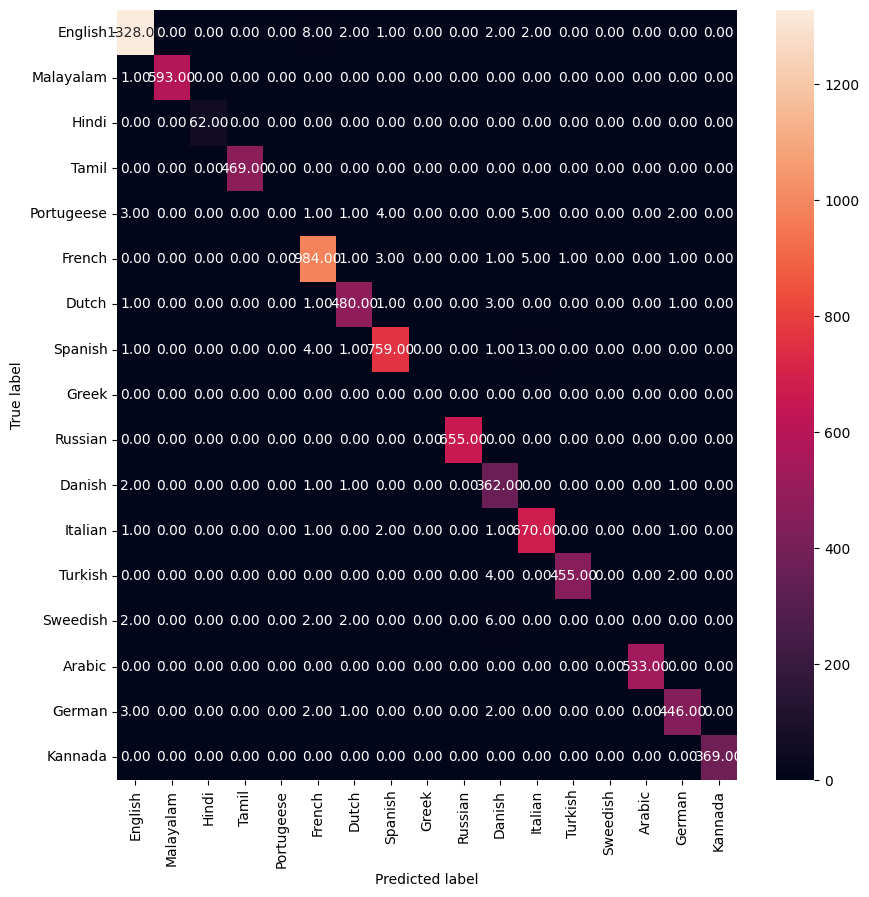

In [81]:
print("Using Langdetect")
df['langdetect'] = df['Text'].apply(check_lang)
df['langdetect'] = df['langdetect'].apply(iso2str)
multiclass_report(df['Language'], df['langdetect'], df['Language'].unique())


- LangId


Using Langid
Accuracy: 0.7907516687626971
Precision: 0.7907516687626971
Recall: 0.7907516687626971


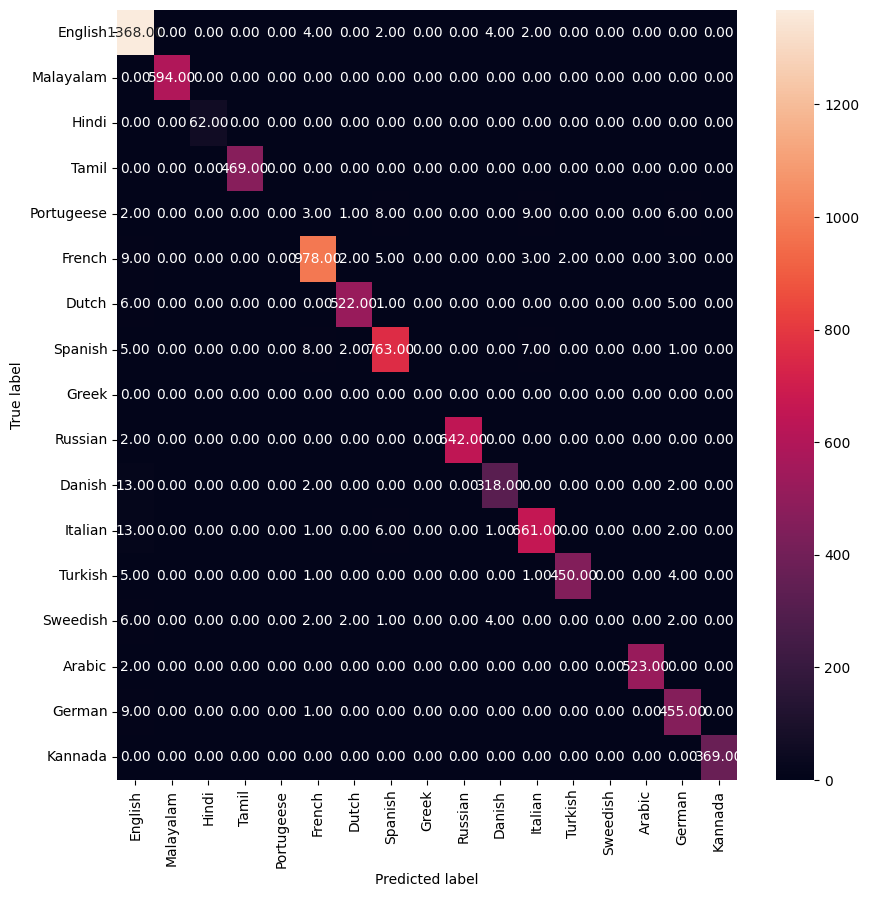

In [82]:
print("Using Langid")
df['langid'] = df['Text'].apply(langid.classify)
df['langid'] = df['langid'].apply(lambda x: x[0])
df['langid'] = df['langid'].apply(iso2str)
multiclass_report(df['Language'], df['langid'], df['Language'].unique())

- FastText

Using Fasttext
Accuracy: 0.8179355712489117
Precision: 0.8179355712489117
Recall: 0.8179355712489117


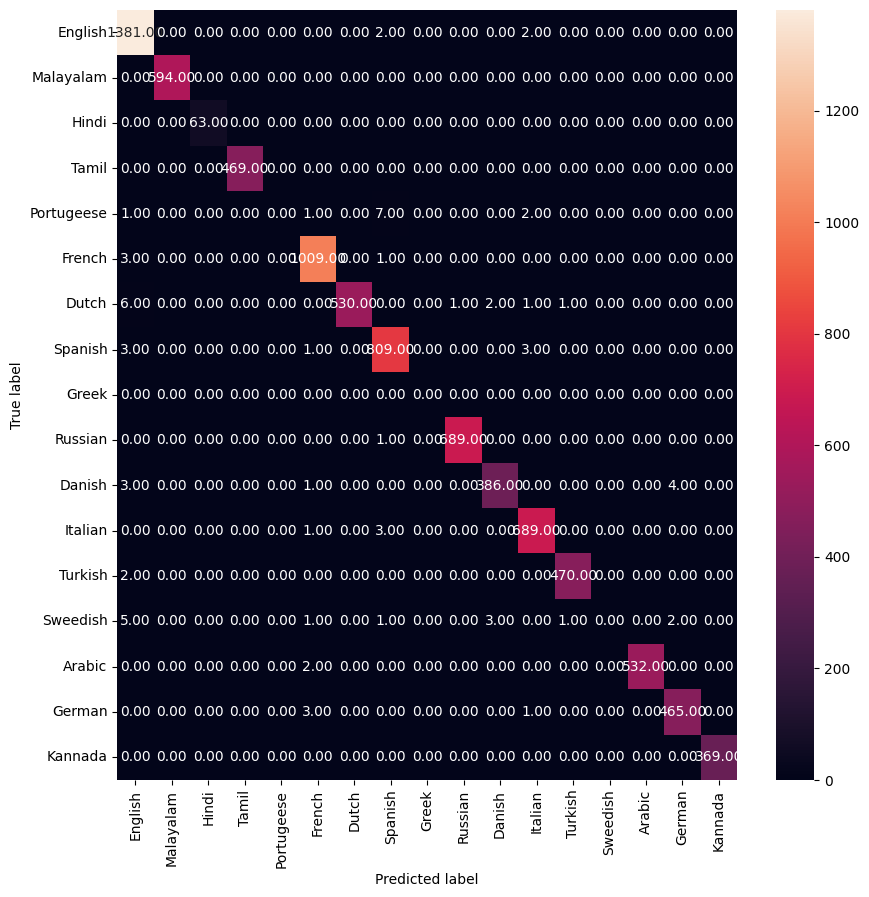

In [83]:
model = LanguageIdentification()

print("Using Fasttext")
df['Text'] = df['Text'].apply(lambda x: x.replace("\n", " "))
df['fasttext'] = df['Text'].apply(model.predict_lang)
df['fasttext'] = df['fasttext'].apply(iso2str)
multiclass_report(df['Language'], df['fasttext'], df['Language'].unique())

## Using Embeddings

### Using SentenceTransformer

In [84]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])

df['Embedding'] = df['Text'].apply(stEmbedding)


In [85]:
df.head()

Text Language   
0   Nature, in the broadest sense, is the natural...  English  \
1  "Nature" can refer to the phenomena of the phy...  English   
2  The study of nature is a large, if not the onl...  English   
3  Although humans are part of nature, human acti...  English   
4  [1] The word nature is borrowed from the Old F...  English   

                                           Embedding  
0  [0.06381069, -0.020321652, 0.022865318, 0.0803...  
1  [0.04028564, 0.013012324, 0.010959669, 0.13800...  
2  [0.073503, 0.061530456, 0.083170004, 0.0722697...  
3  [0.049719308, -0.046503387, 0.066873305, 0.047...  
4  [0.026049394, 0.031227034, 0.0108607905, 0.117...

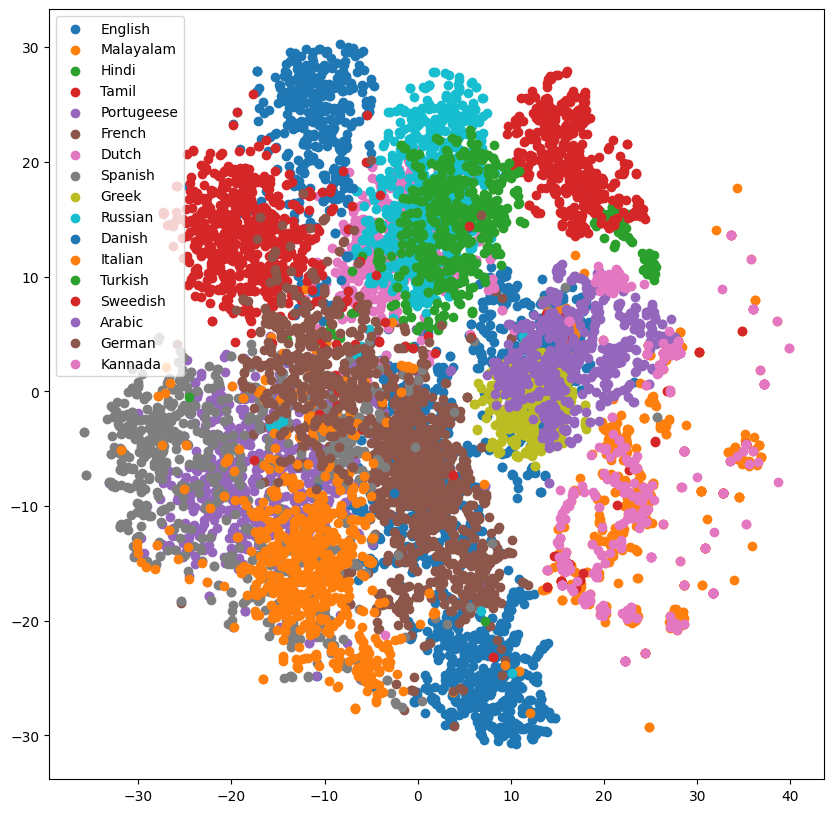

In [86]:
Tsen(df['Embedding'], df['Language'], 3)

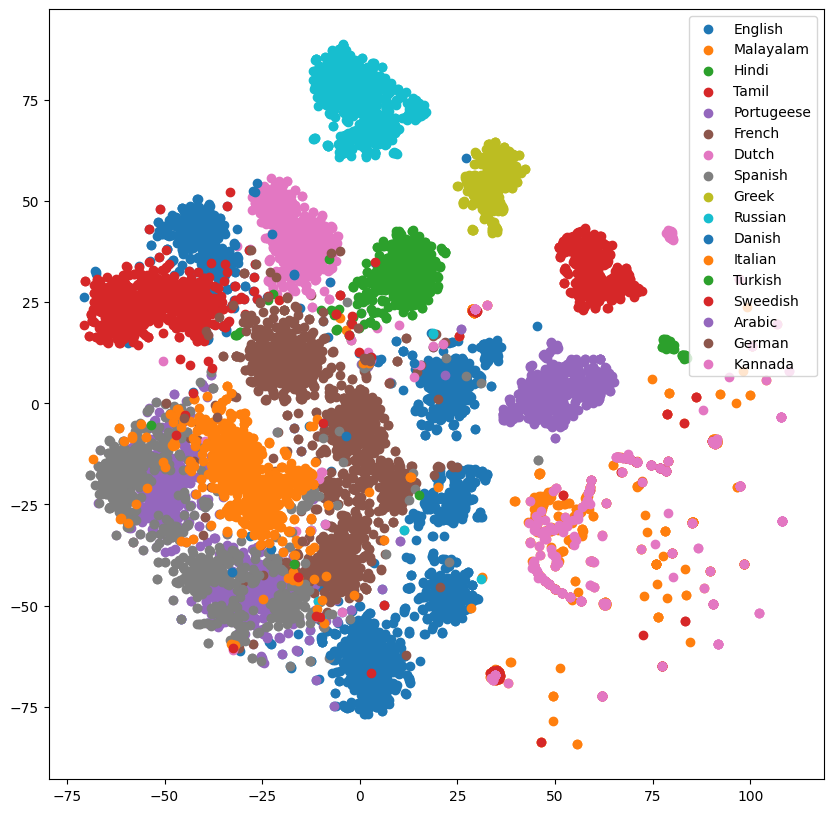

In [87]:
Tsen(df['Embedding'], df['Language'], 2)

In [88]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

#### Multi-Layer Perceptron

- Model : 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                6545      
                                                                 
Total params: 6,545
Trainable params: 6,545
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 1ms/step
Accuracy	:	0.9414893617021277
Precision	:	0.9494188747305293
Recall	:	0.9414893617021277
F1 score	:	0.9367905093837596


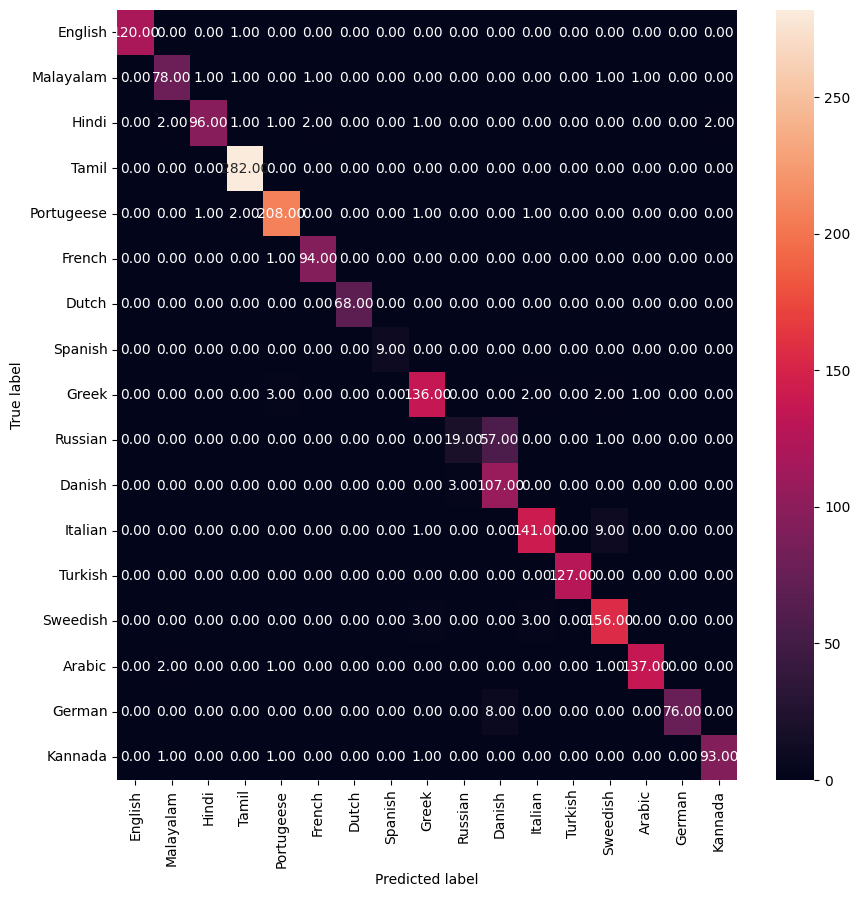

In [89]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=0, 
    layer_types=[], 
    layer_units=[], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP1', X_train, X_test, y_train, y_test)


- Model : 2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               49280     
                                                                 
 dense_2 (Dense)             (None, 17)                2193      
                                                                 
Total params: 51,473
Trainable params: 51,473
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 1ms/step
Accuracy	:	0.9511605415860735
Precision	:	0.9593883640475657
Recall	:	0.9511605415860735
F1 score	:	0.9511632808871107


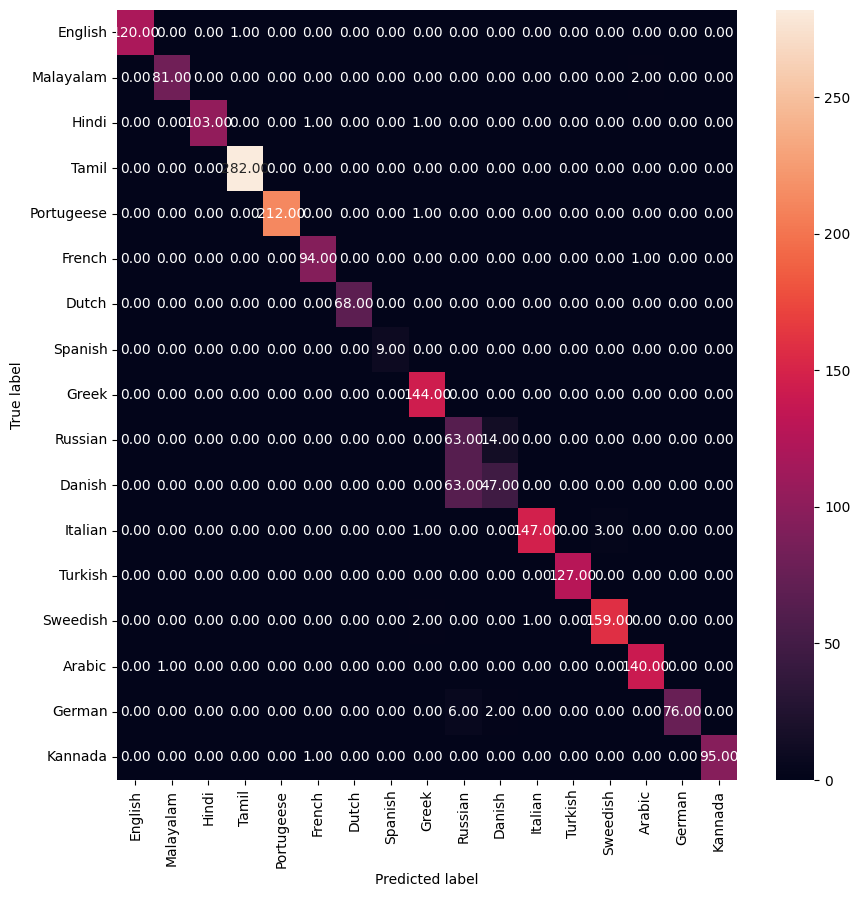

In [90]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=1, 
    layer_types=['Dense'], 
    layer_units=[128], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               49280     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 17)                2193      
                                                                 
Total params: 51,473
Trainable params: 51,473
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 1ms/step
Accuracy	:	0.9584139264990329
Precision	:	0.9602661346464563
Recall	:	0.9584139264990329
F1 score	:	0.9567890933056302


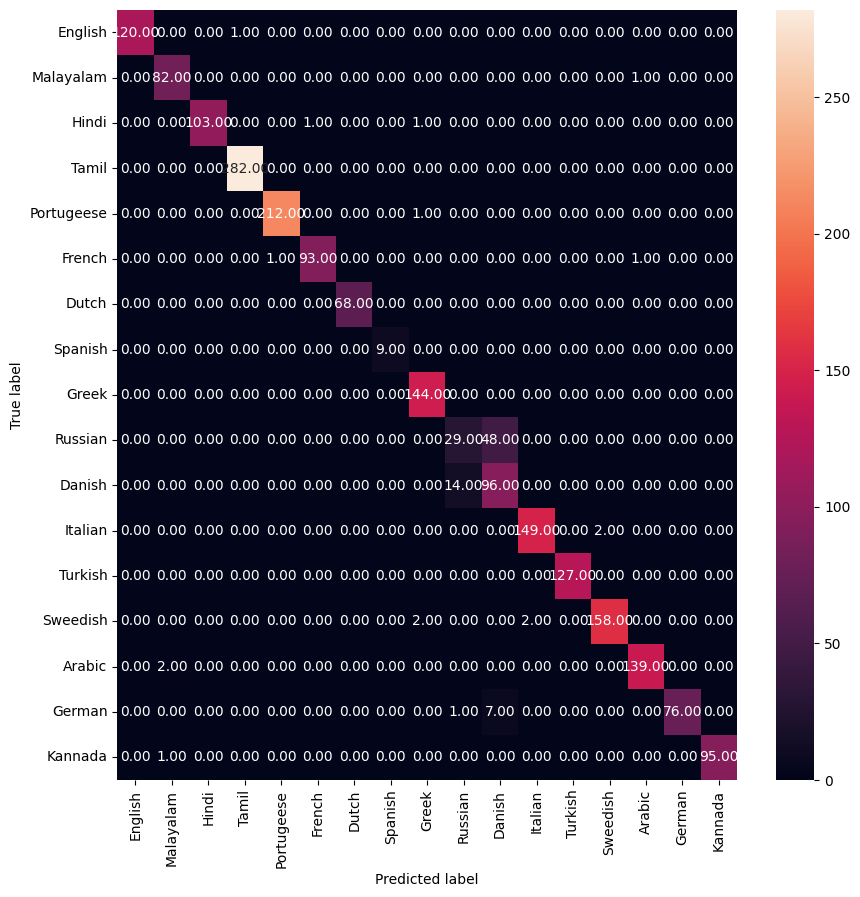

In [91]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=2, 
    layer_types=['Dense', 'Dropout'], 
    layer_units=[128, 0.2], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP3', X_train, X_test, y_train, y_test)


- Model : 4

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               49280     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 17)                1105      
                                                                 
Total params: 58,641
Trainable params: 58,641
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 3ms/step
Accuracy	:	0.9598646034816247
Precision	:	0.961628173680395
Recall	:	0.9598646034816247
F1 score	:	0.9585702164840313


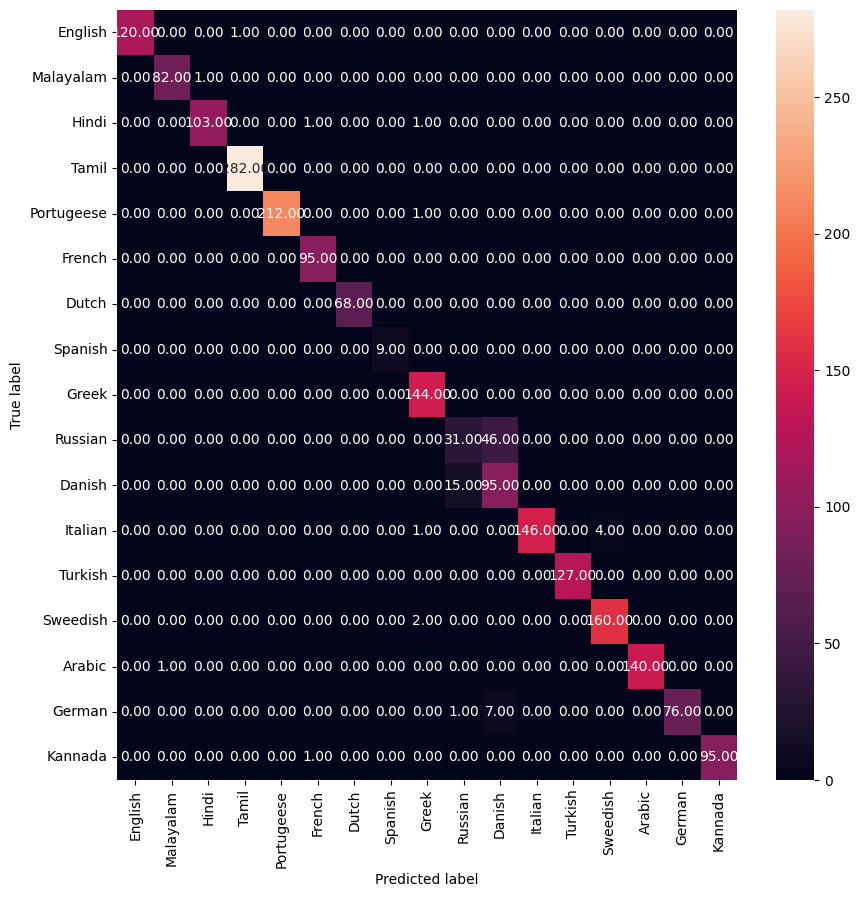

In [92]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=3, 
    layer_types=['Dense', 'Dropout', 'Dense'], 
    layer_units=[128, 0.2, 64], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP4', X_train, X_test, y_train, y_test)


- Model : 5

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               49280     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 17)                1105      
                                                                 
Total params: 58,641
Trainable params: 58,641
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 2ms/st

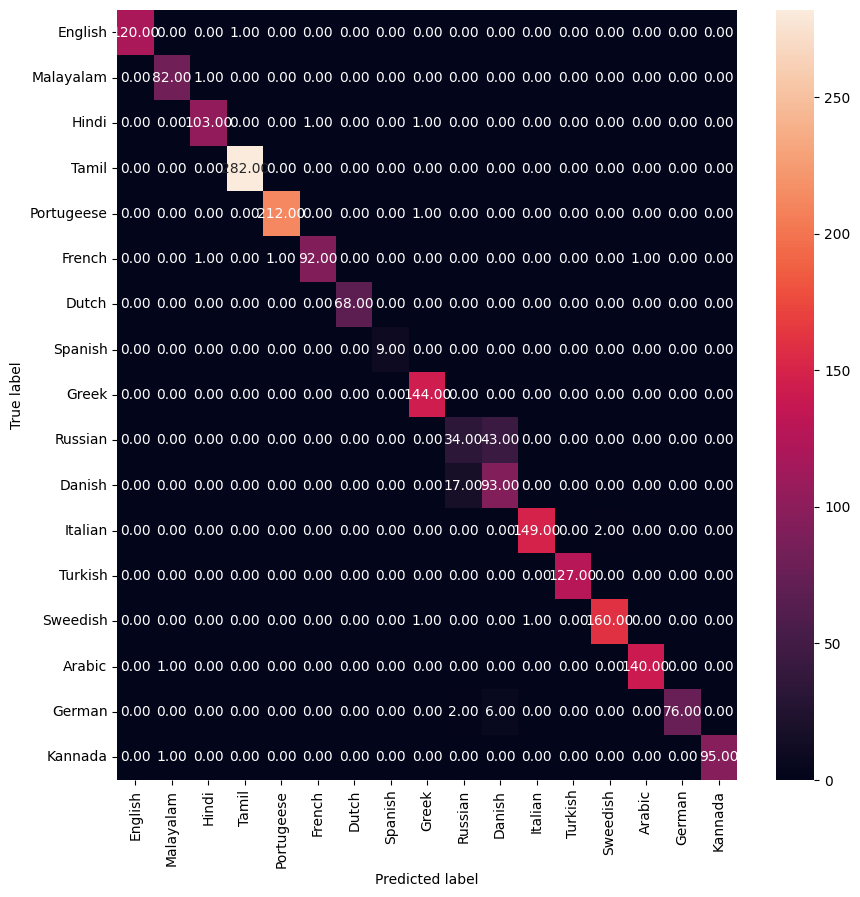

In [93]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=4, 
    layer_types=['Dense', 'Dropout', 'Dense', 'Dropout'], 
    layer_units=[128, 0.2, 64, 0.2], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP5', X_train, X_test, y_train, y_test)


#### Long Short Term Memory

- Model : 1

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 384, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_11 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:20:01.189989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:20:01.192960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:20:01.194501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 3s 45ms/step
Accuracy	:	0.5904255319148937
Precision	:	0.5871885965726061
Recall	:	0.5904255319148937
F1 score	:	0.5767902142108712


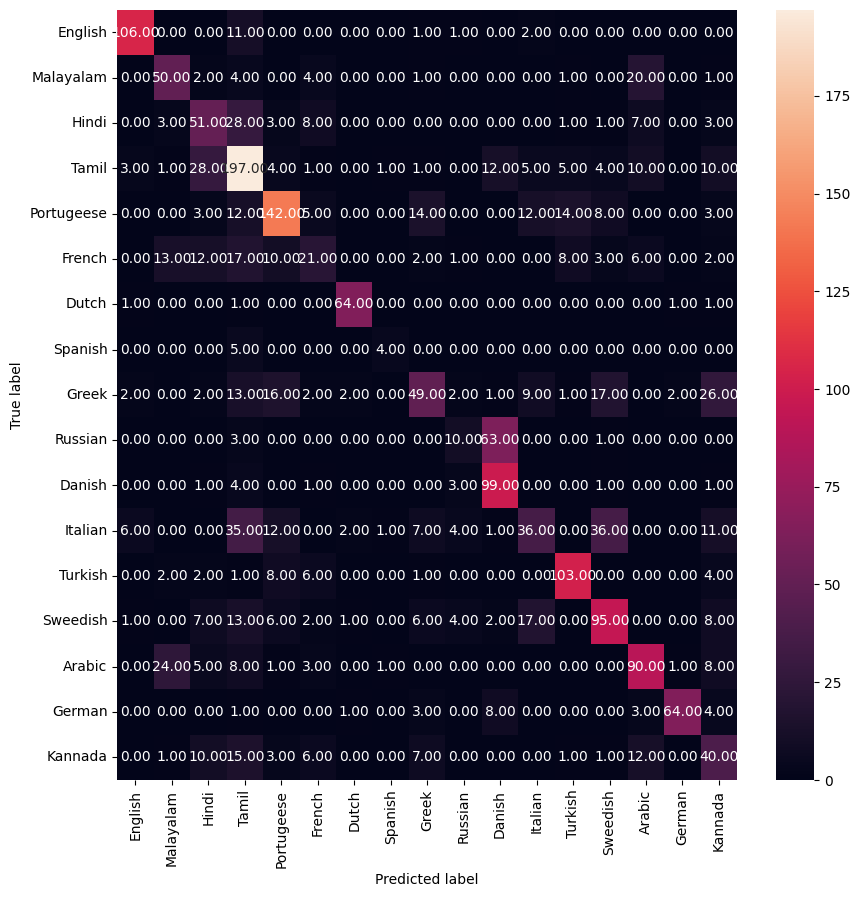

In [94]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=1, 
    layer_types=['LSTM'], 
    layer_units=[64], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 384, 1)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:20:05.946110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:20:05.947922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:20:05.949237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/65 [..............................] - ETA: 28s

2023-05-04 05:20:06.288840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:20:06.291140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:20:06.292482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 3s 44ms/step
Accuracy	:	0.629110251450677
Precision	:	0.6326962289698174
Recall	:	0.629110251450677
F1 score	:	0.6127089472618938


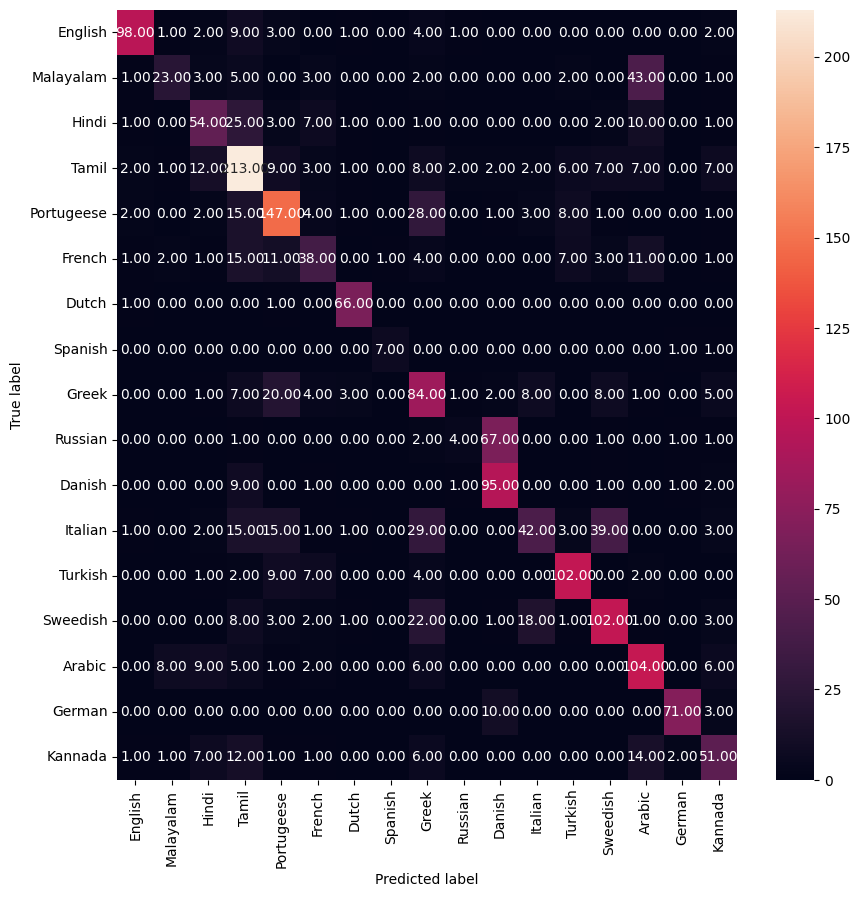

In [95]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=2, 
    layer_types=['LSTM', 'Dropout'],
    layer_units=[64, 0.2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 384, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:20:11.099061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:20:11.101142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:20:11.104243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 4s 48ms/step
Accuracy	:	0.6353965183752418
Precision	:	0.640815619873759
Recall	:	0.6353965183752418
F1 score	:	0.6209257304517412


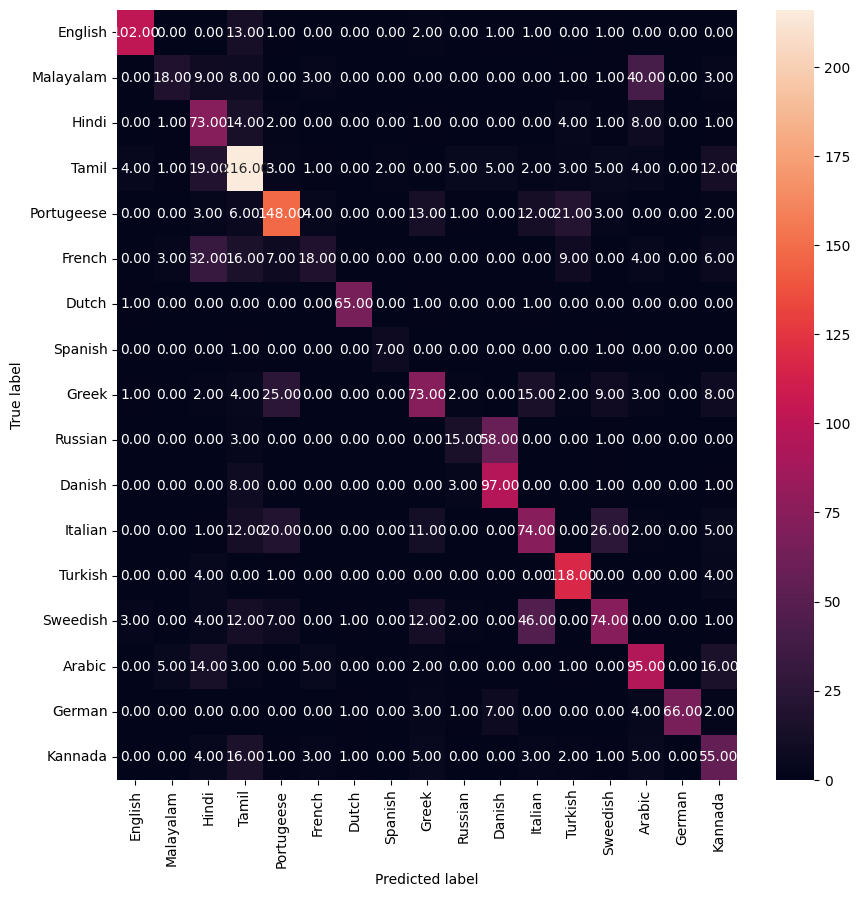

In [96]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=3, 
    layer_types=['LSTM', 'Dropout', 'Dense'],
    layer_units=[64, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM3', X_train, X_test, y_train, y_test)


- Model : 4

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 384, 1)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-trai

2023-05-04 05:20:16.391417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:20:16.393485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:20:16.394960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 4s 47ms/step
Accuracy	:	0.6160541586073501
Precision	:	0.5926537626859625
Recall	:	0.6160541586073501
F1 score	:	0.5933579944524192


/home/arrry/anaconda3/envs/Language/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



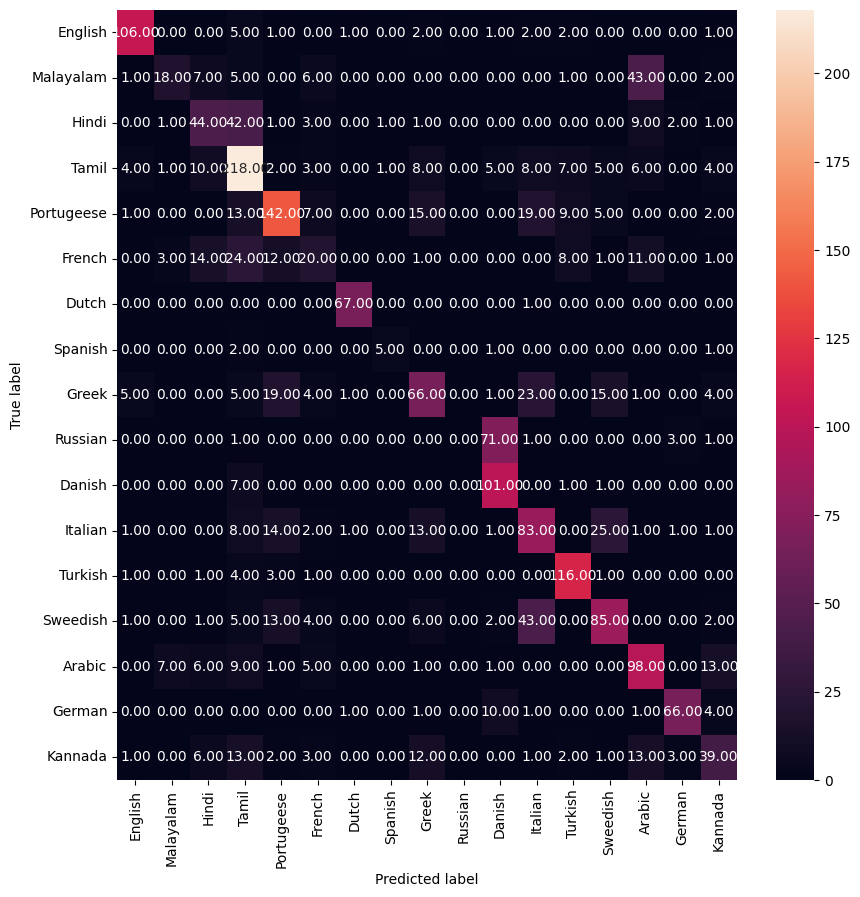

In [97]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=4, 
    layer_types=['LSTM', 'Dropout', 'Dense', 'Dropout'],
    layer_units=[64, 0.2, 32, 0.2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM4', X_train, X_test, y_train, y_test)

#### Convolutional Neural Network

- Model : 1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 384, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 382, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 191, 64)          0         
 )                                                               
                                                                 
 dropout_8 (Dropout)         (None, 191, 64)           0         
                                                                 
 flatten (Flatten)           (None, 12224)             0         
                                                                 
 dense_17 (Dense)            (None, 17)                207825    
                                                      

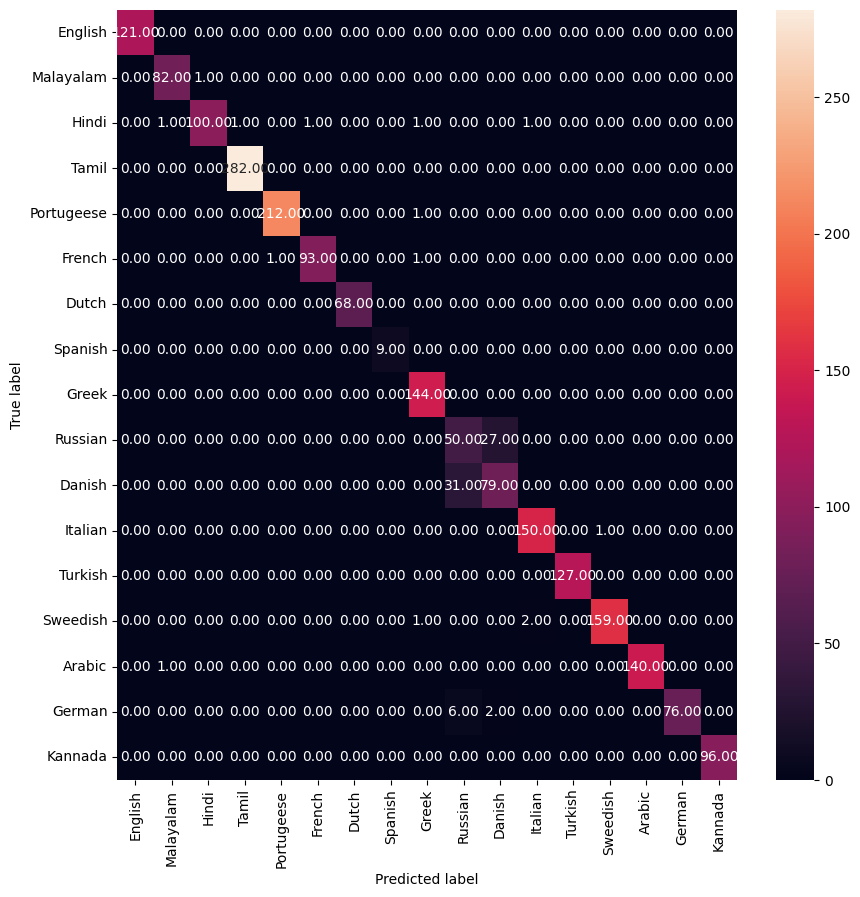

In [98]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=4, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 384, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 382, 64)           256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 191, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 191, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 94, 64)           0         
 1D)                                                 

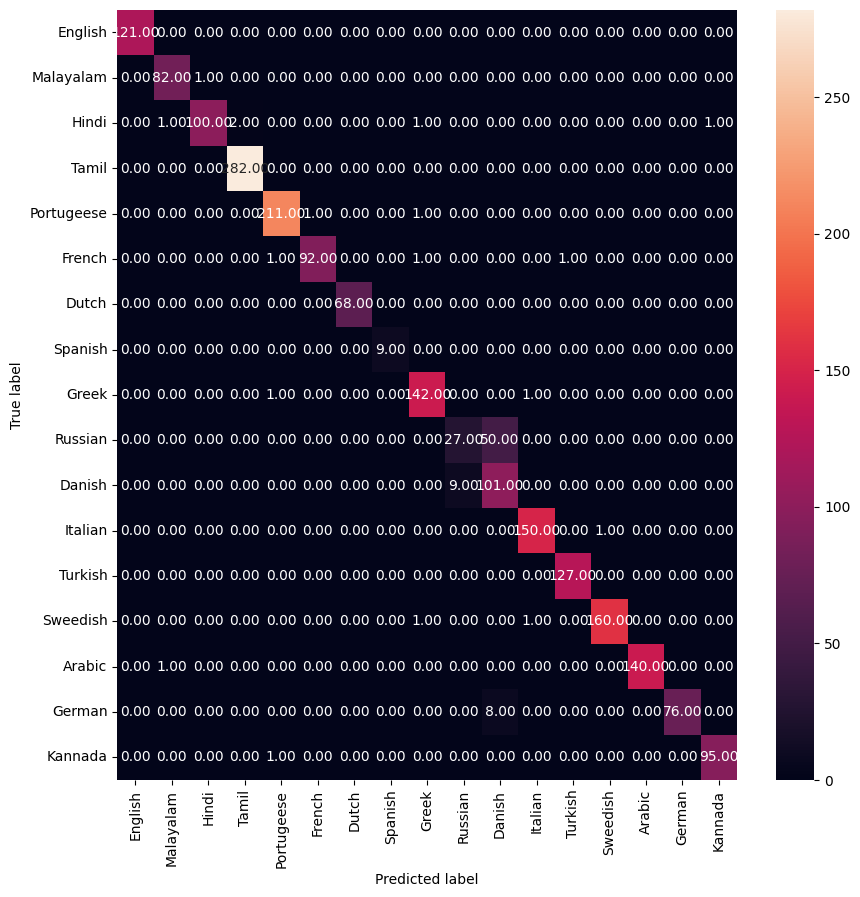

In [99]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=6, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Conv1D', 'MaxPooling1D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 384, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 382, 64)           256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 191, 64)          0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 191, 64)           0         
                                                                 
 flatten_2 (Flatten)         (None, 12224)             0         
                                                                 
 dense_19 (Dense)            (None, 17)                207825    
                                                     

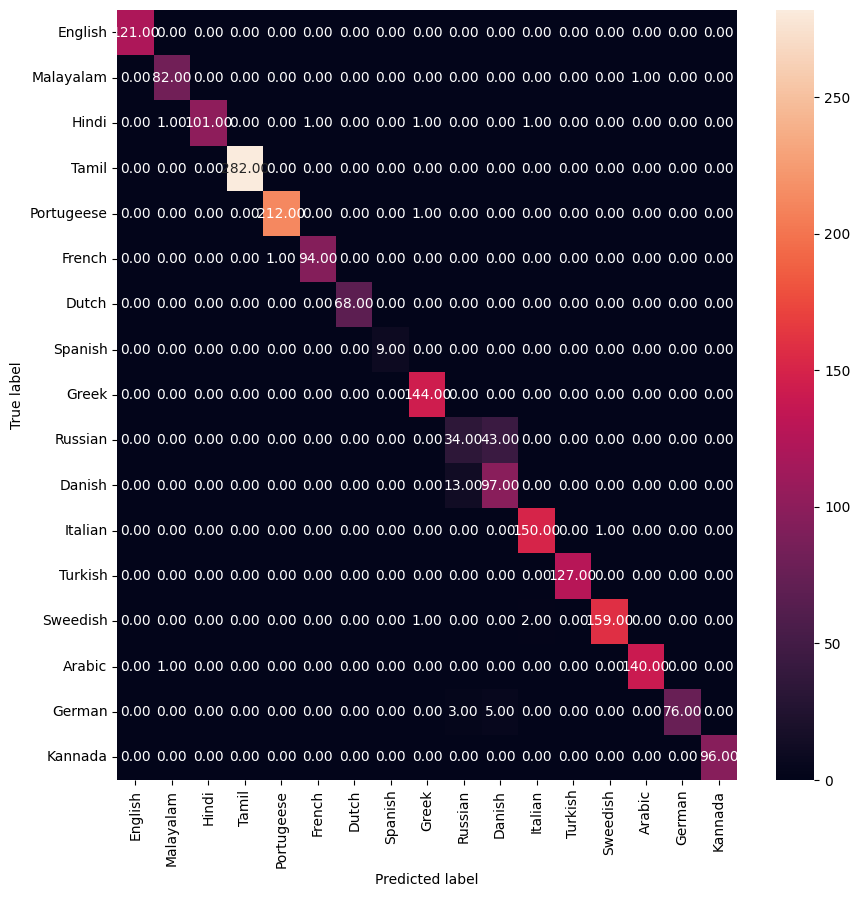

In [100]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=4, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 384, 1)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 382, 64)           256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 191, 64)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 191, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 94, 64)           0         
 1D)                                                 

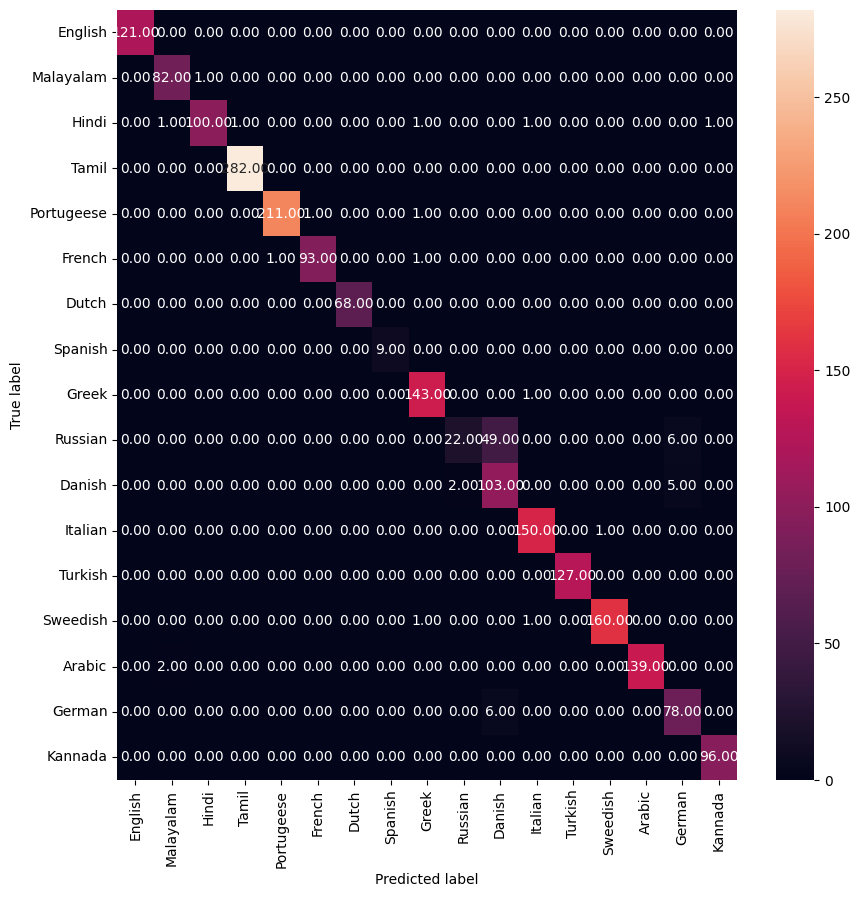

In [101]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=6, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Conv2D', 'MaxPooling2D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN4', X_train, X_test, y_train, y_test)

### Using FastText

In [102]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])


df['Embedding'] = df['Text'].apply(ftEmbedding)

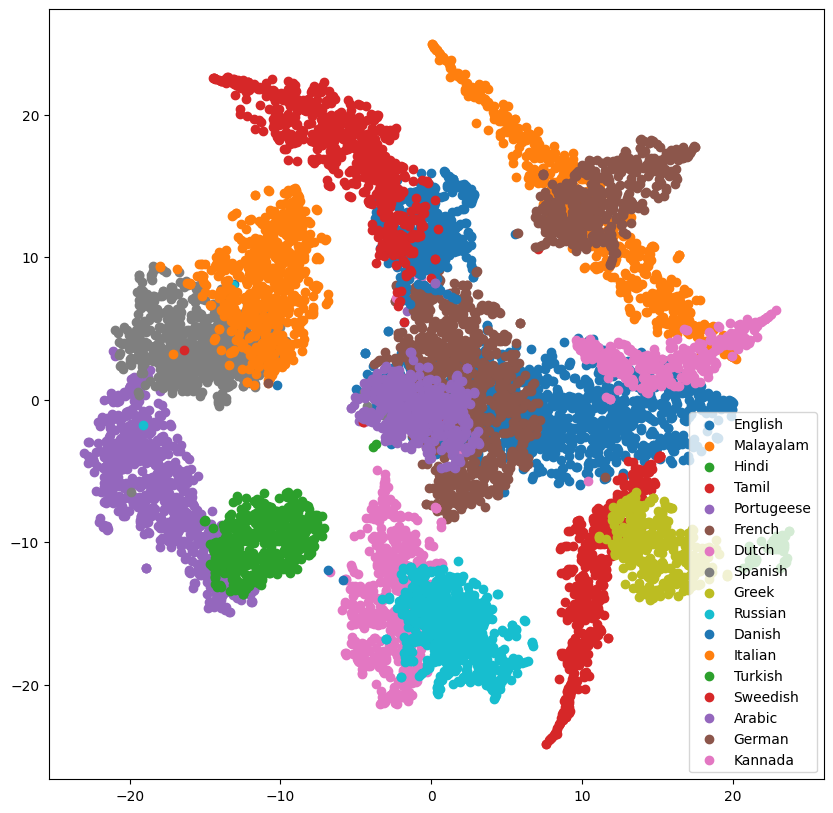

In [103]:
Tsen(df['Embedding'], df['Language'], 3)

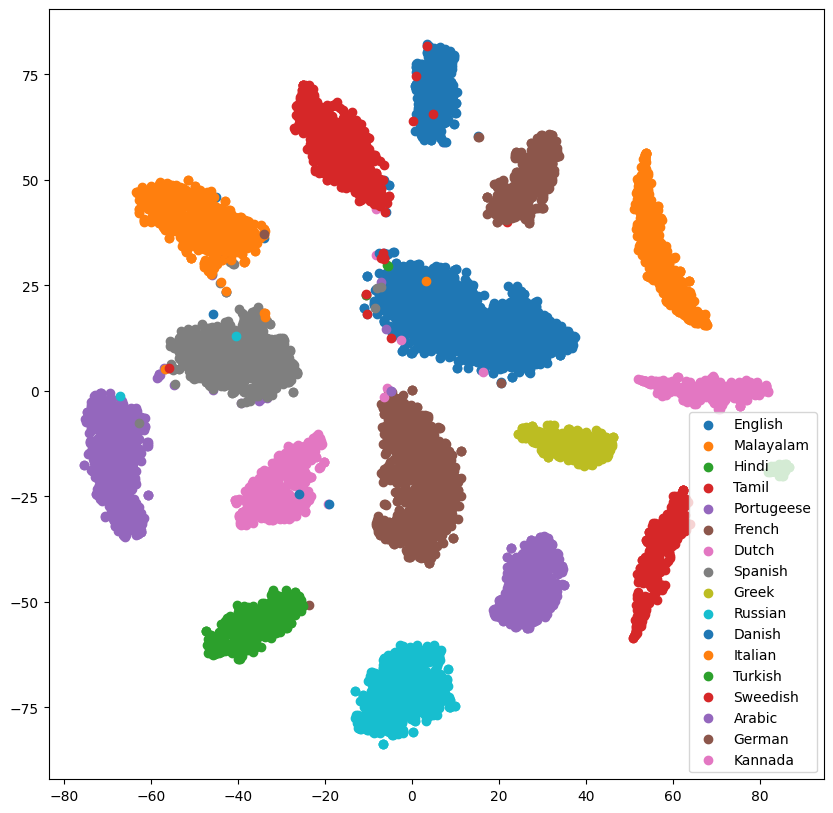

In [104]:
Tsen(df['Embedding'], df['Language'], 2)

In [105]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

#### Multi-Layer Perceptron

- Model: 1

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 17)                289       
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9903288201160542
Precision	:	0.9905808166830016
Recall	:	0.9903288201160542
F1 score	:	0.9903487480517019


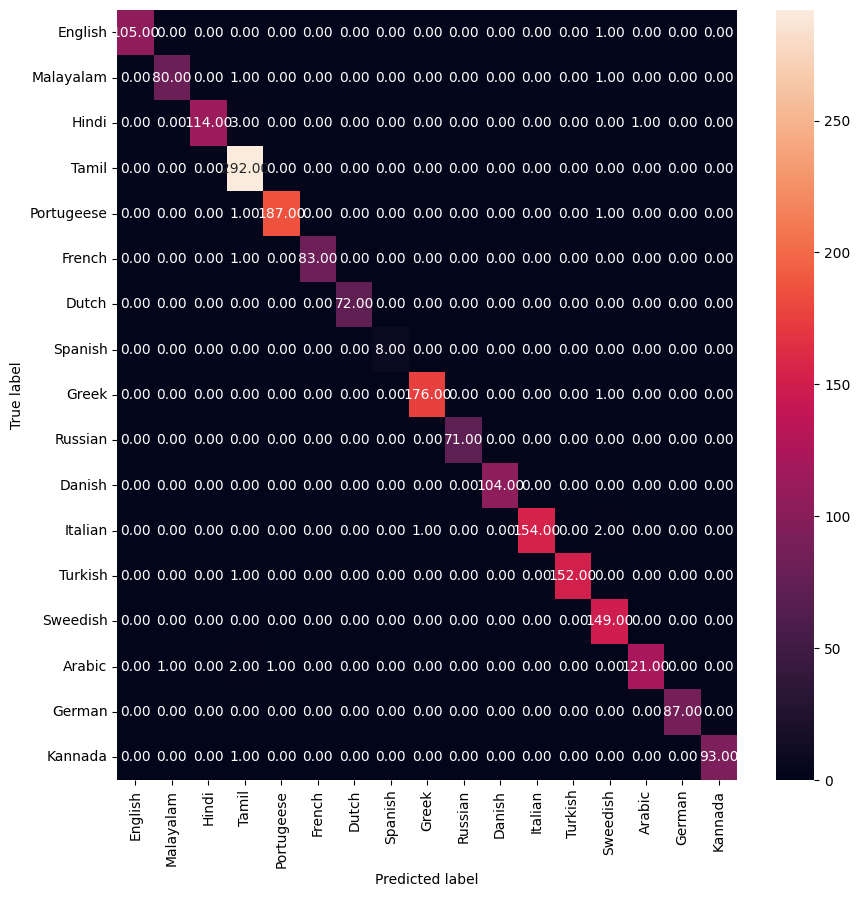

In [106]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=0, 
    layer_types=[], 
    layer_units=[], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               2176      
                                                                 
 dense_23 (Dense)            (None, 17)                2193      
                                                                 
Total params: 4,369
Trainable params: 4,369
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9975822050290135
Precision	:	0.997596957676294
Recall	:	0.9975822050290135
F1 score	:	0.9975813710458082


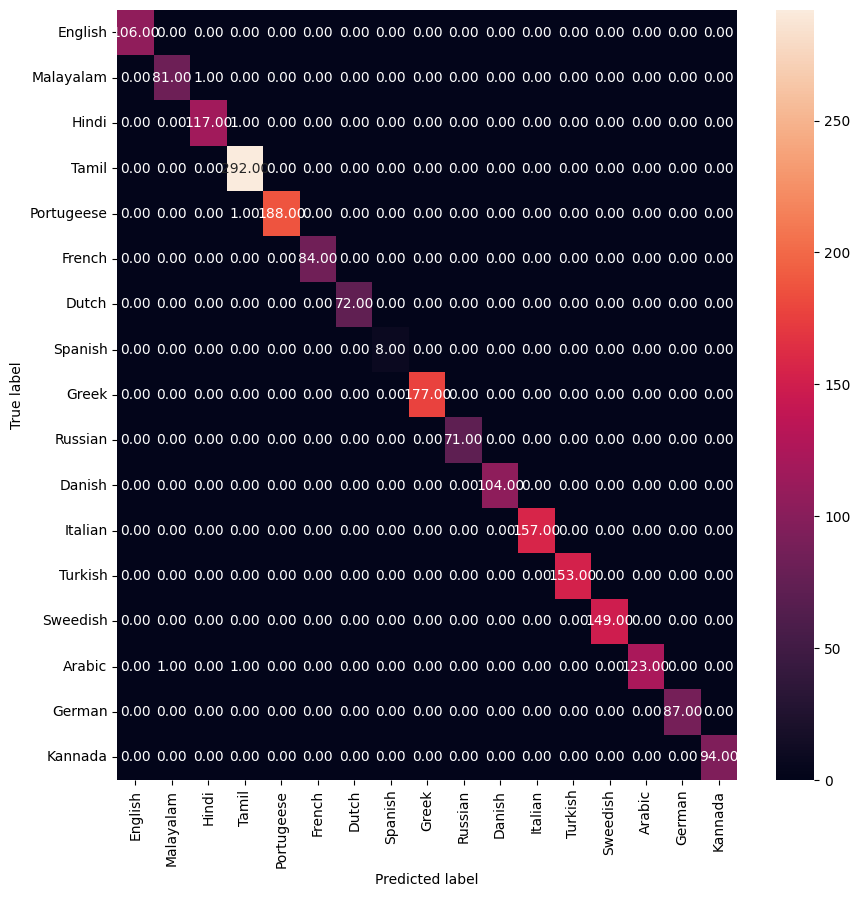

In [107]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=1, 
    layer_types=['Dense'], 
    layer_units=[128], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               2176      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 17)                2193      
                                                                 
Total params: 4,369
Trainable params: 4,369
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9975822050290135
Precision	:	0.9975988840189643
Recall	:	0.9975822050290135
F1 score	:	0.9975796900565562


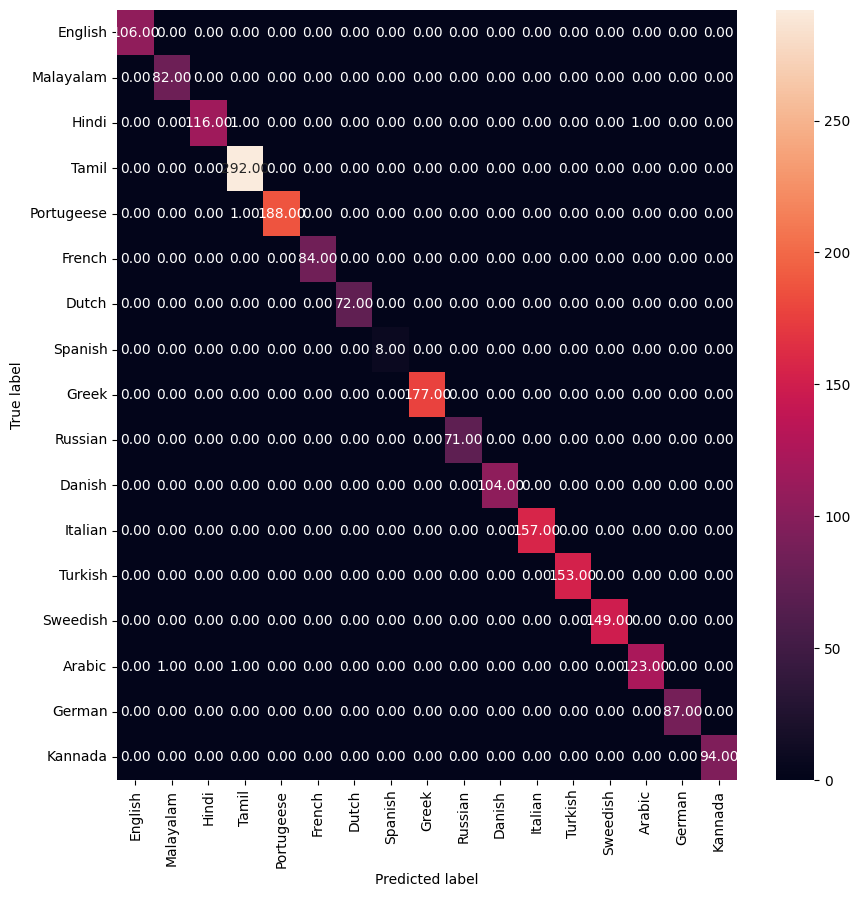

In [108]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=2, 
    layer_types=['Dense', 'Dropout'], 
    layer_units=[128, 0.2], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               2176      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 17)                1105      
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9980657640232108
Precision	:	0.9980755667837735
Recall	:	0.9980657640232108
F1 score	:	0.9980641675901776


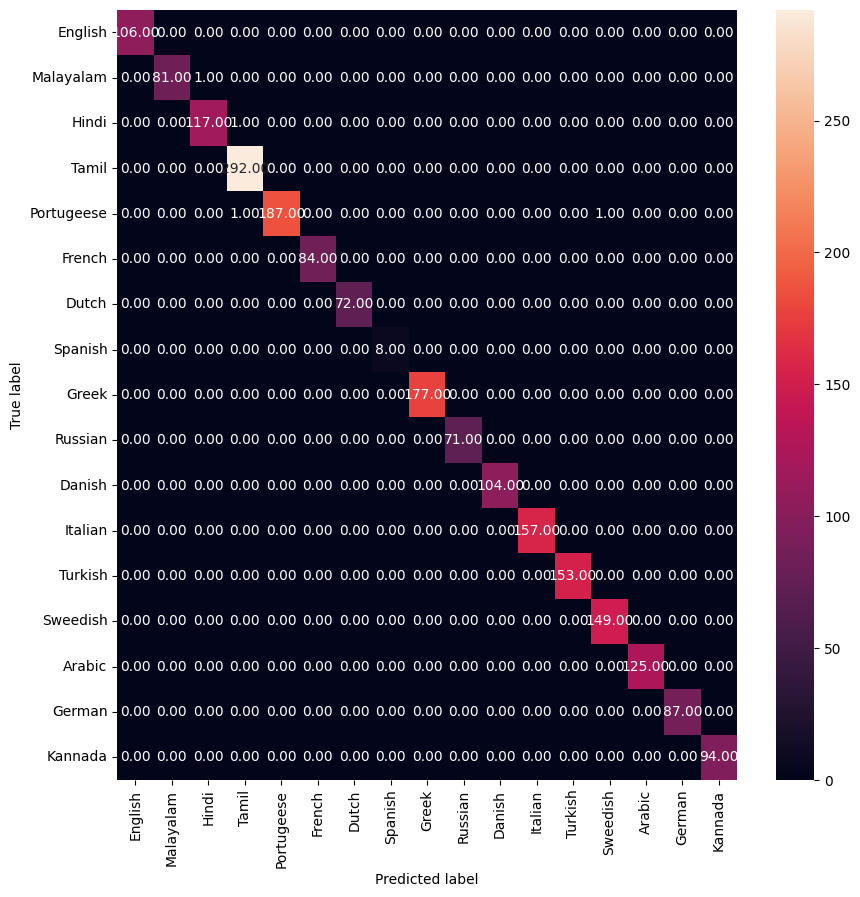

In [109]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=3, 
    layer_types=['Dense', 'Dropout', 'Dense'], 
    layer_units=[128, 0.2, 64], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP4', X_train, X_test, y_train, y_test)

- Model : 5

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               2176      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 17)                1105      
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 1ms/s

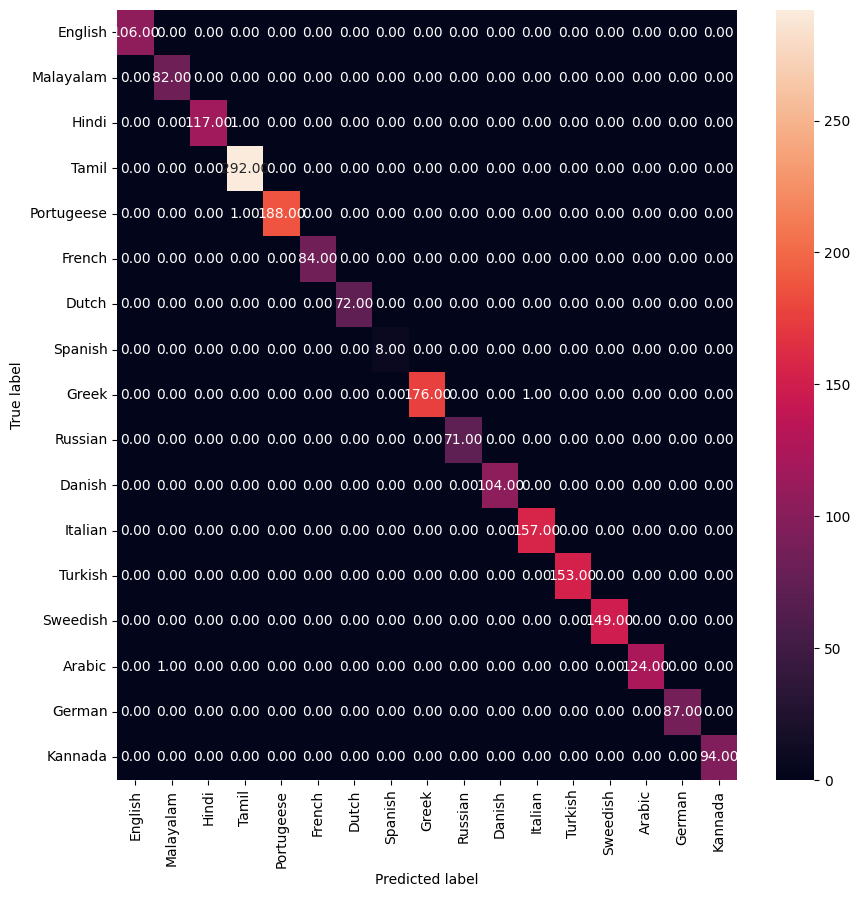

In [110]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=4, 
    layer_types=['Dense', 'Dropout', 'Dense', 'Dropout'], 
    layer_units=[128, 0.2, 64, 0.2], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP5', X_train, X_test, y_train, y_test)

#### Long Short Term Memory

- Model : 1

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 16, 1)             0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_32 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:24:17.281962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:24:17.284964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:24:17.286729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1s 4ms/step
Accuracy	:	0.9787234042553191
Precision	:	0.9790903364387522
Recall	:	0.9787234042553191
F1 score	:	0.9787874887840774


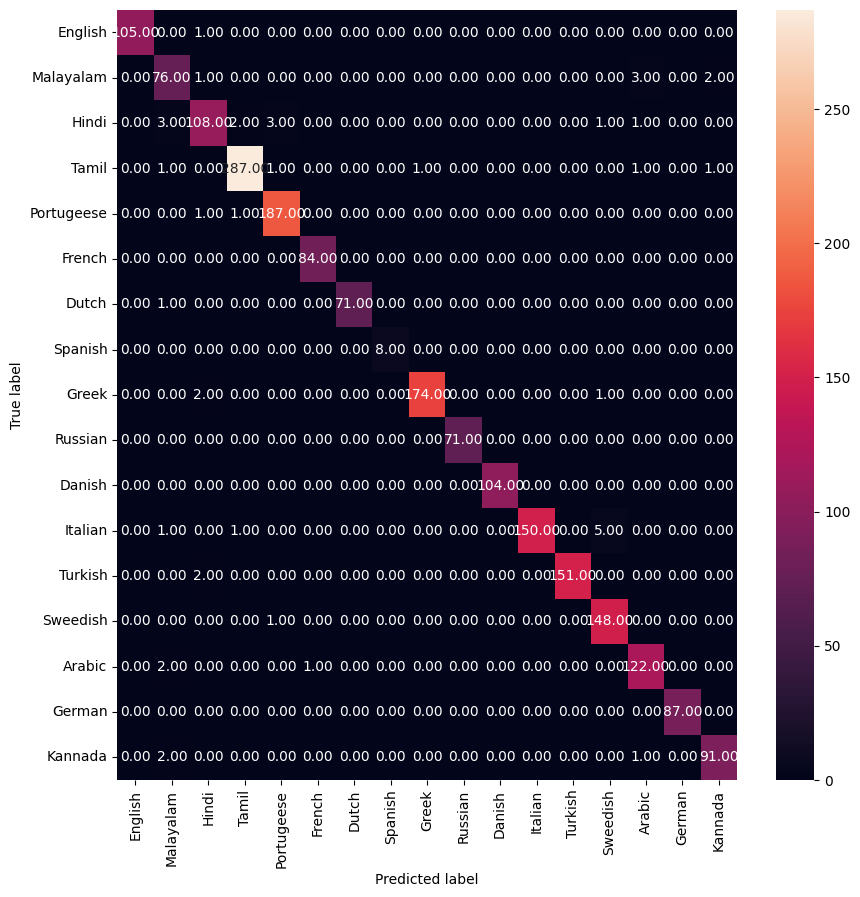

In [111]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=1, 
    layer_types=['LSTM'], 
    layer_units=[64], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_LSTM1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 16, 1)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:24:19.813389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:24:19.816655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:24:19.819110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1s 4ms/step
Accuracy	:	0.9743713733075435
Precision	:	0.9748975040189423
Recall	:	0.9743713733075435
F1 score	:	0.9743203247553586


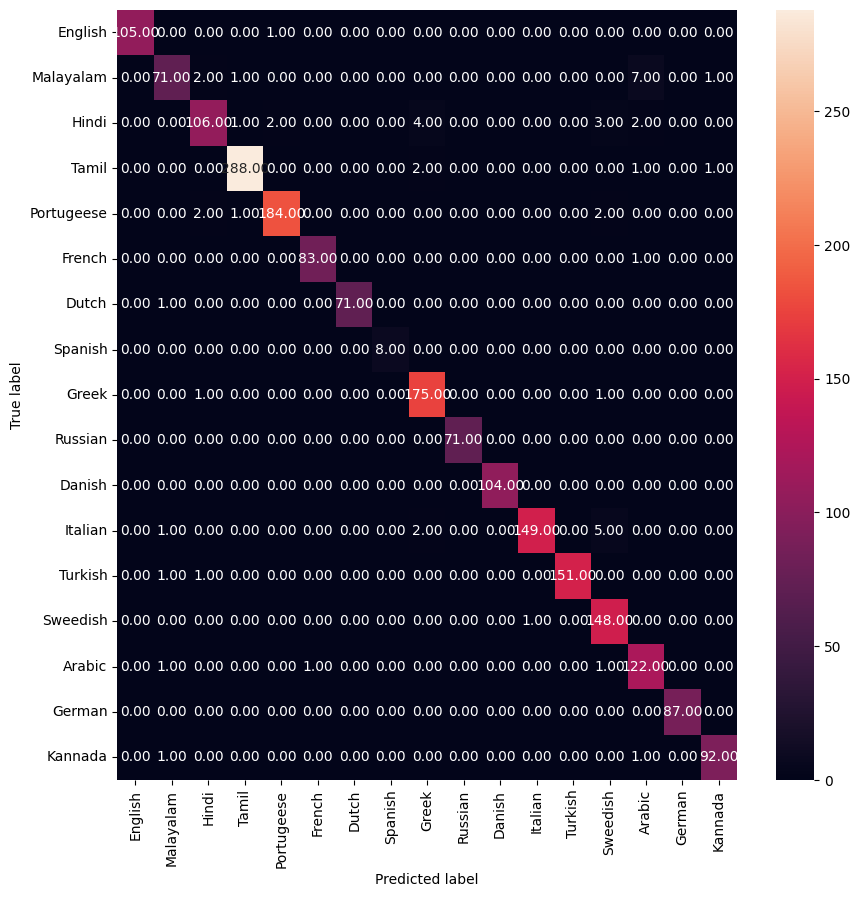

In [112]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=2, 
    layer_types=['LSTM', 'Dropout'],
    layer_units=[64, 0.2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-trainable params: 0
_________________________________________________________________


2023-05-04 05:24:22.938898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:24:22.943530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:24:22.947462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1s 4ms/step
Accuracy	:	0.97678916827853
Precision	:	0.9768910568750782
Recall	:	0.97678916827853
F1 score	:	0.9765761526755022


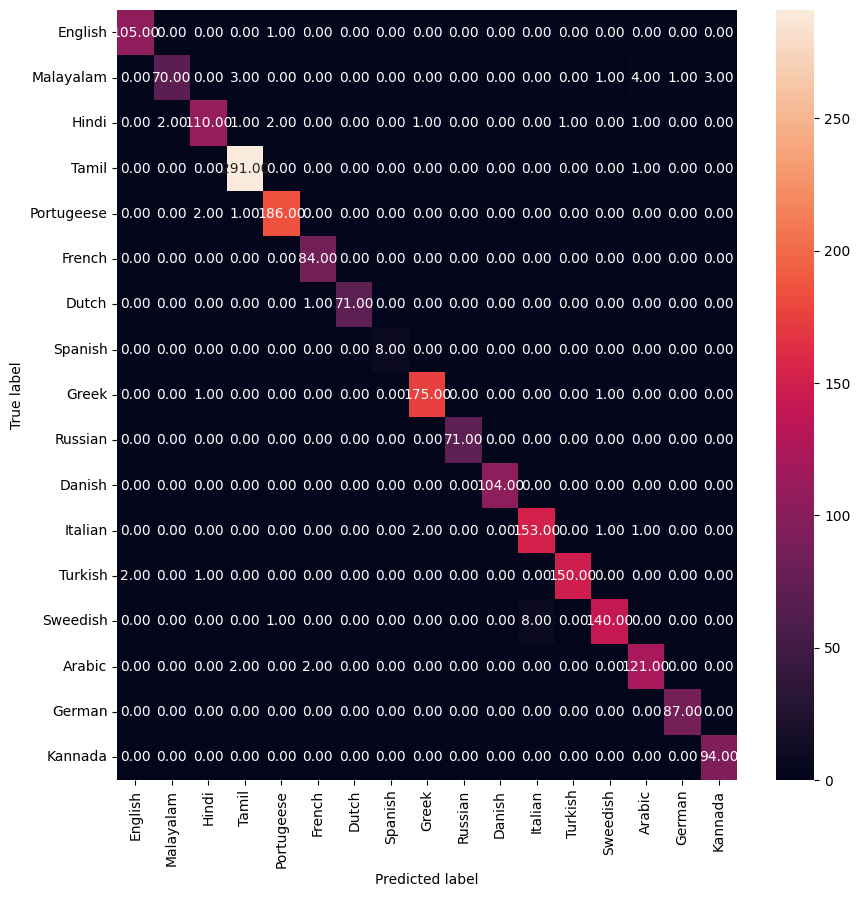

In [113]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=3, 
    layer_types=['LSTM', 'Dropout', 'Dense'],
    layer_units=[64, 0.2, 32],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-tra

2023-05-04 05:24:26.266738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:24:26.269599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:24:26.271230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/65 [..............................] - ETA: 36s

2023-05-04 05:24:26.801456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 05:24:26.803477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 05:24:26.805010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1s 4ms/step
Accuracy	:	0.97678916827853
Precision	:	0.9774672441691851
Recall	:	0.97678916827853
F1 score	:	0.9768577230742026


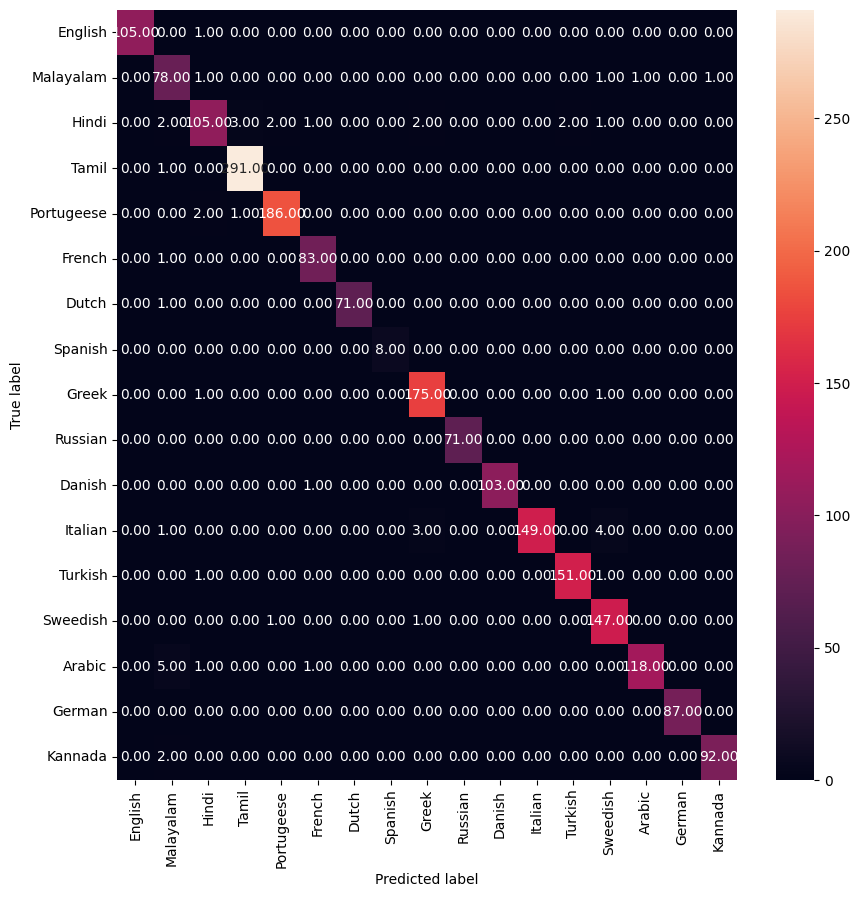

In [114]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=4, 
    layer_types=['LSTM', 'Dropout', 'Dense', 'Dropout'],
    layer_units=[64, 0.2, 32, 0.2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM4', X_train, X_test, y_train, y_test)

#### Convolutional Nural Network

- Model : 1

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 14, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 dropout_20 (Dropout)        (None, 7, 64)             0         
                                                                 
 flatten_4 (Flatten)         (None, 448)               0         
                                                                 
 dense_38 (Dense)            (None, 17)                7633      
                                                     

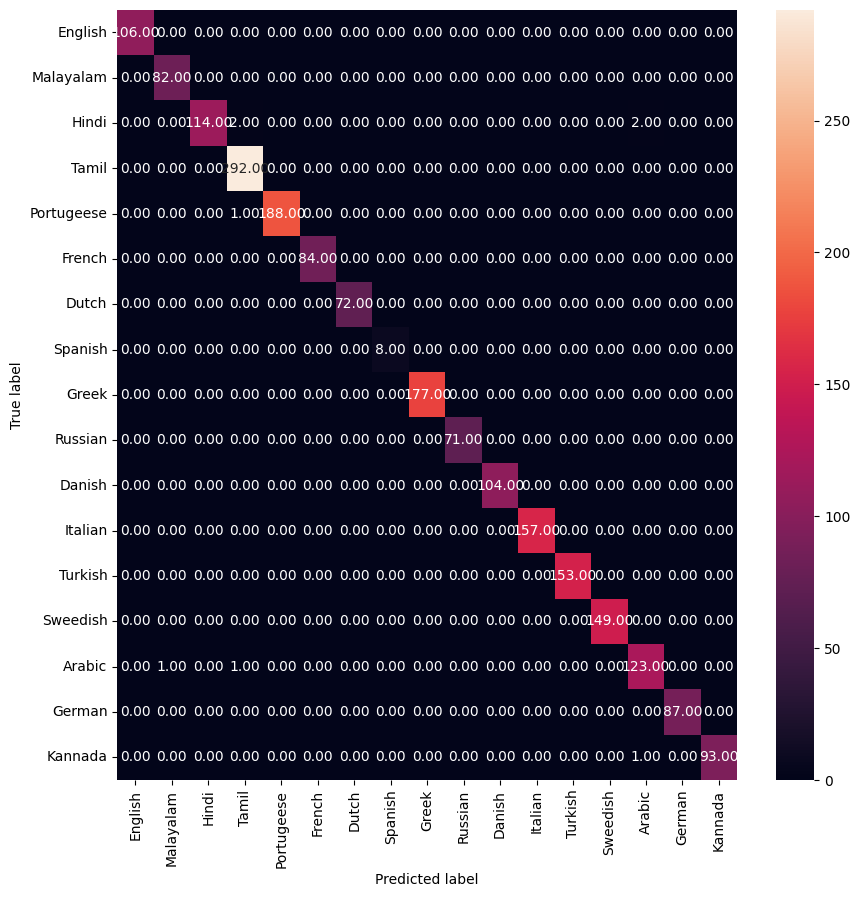

In [115]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=4, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_13 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 64)            256       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 7, 64)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2, 64)            0         
 1D)                                                 

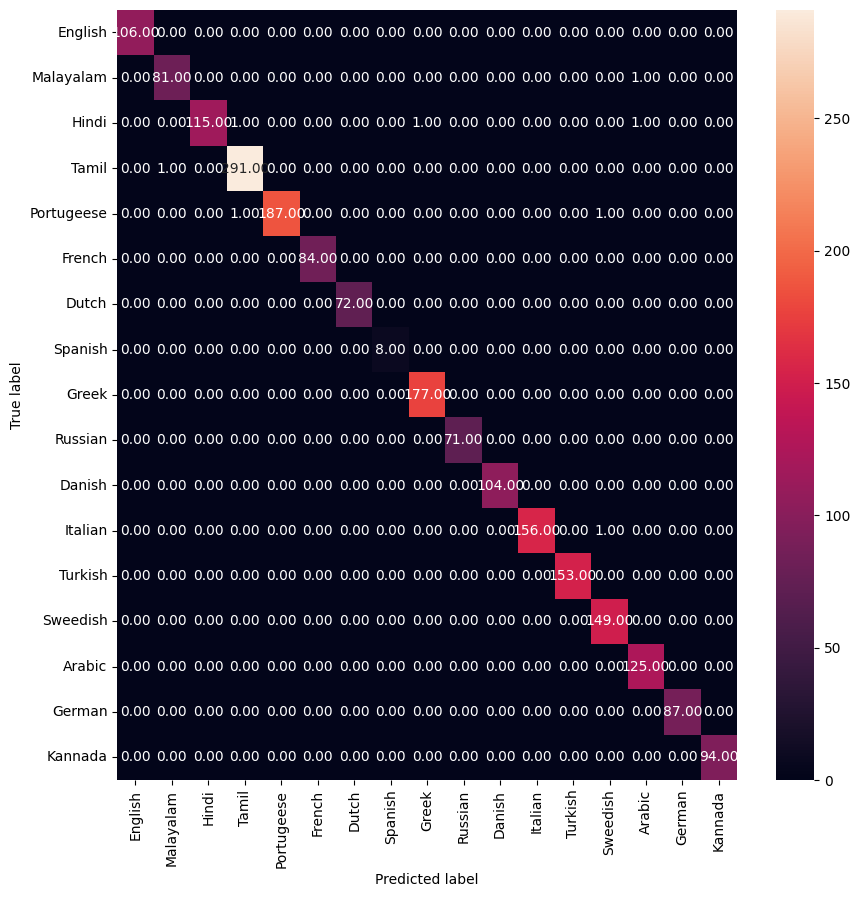

In [116]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=6, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Conv1D', 'MaxPooling1D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_9 (Conv1D)           (None, 14, 64)            256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 7, 64)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 5, 64)             12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                

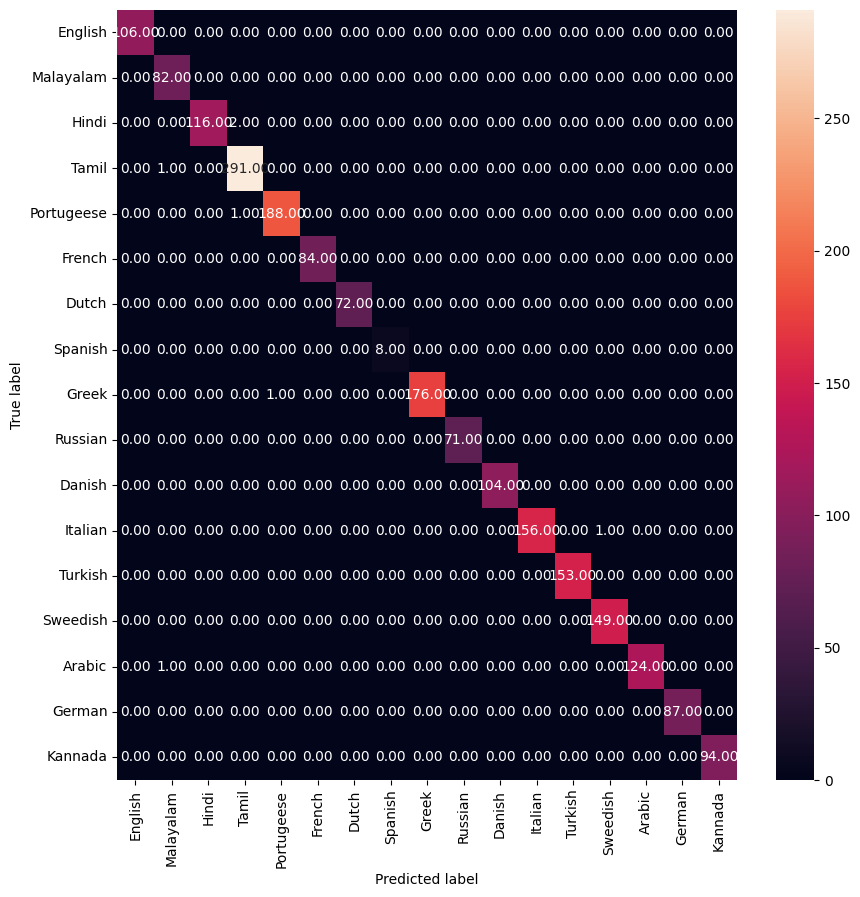

In [117]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=6, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Conv2D', 'MaxPooling2D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN3', X_train, X_test, y_train, y_test)